In [193]:
from sklearn.naive_bayes import MultinomialNB
from audioop import cross
from contextlib import redirect_stdout
from sklearn.model_selection import StratifiedKFold
from mealpy.swarm_based import AO, HGS, SSA, MRFO, HHO
from matplotlib import pyplot
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, auc
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std

DEFAULT_PARAMS = [0.0001, 0.1, 1e-3]

In [194]:
EN = pd.read_csv(f'./input/enron/messages.csv').fillna(' ')
X_EN = np.array(EN['message'])
y_EN = np.array(EN['label'])

LS = pd.read_csv(f'./input/ling_spam/messages.csv').fillna(' ')
X_LS = np.array(LS['message'])
y_LS = np.array(LS['label'])

SA = pd.read_csv(f'./input/spam_assasin/messages.csv').fillna(' ')
X_SA = np.array(SA['message'])
y_SA = np.array(SA['label'])

In [120]:
def resolve_dataset(name):
    if (name == 'EN'):
        return [X_EN.copy(), y_EN.copy()]
    elif (name == 'LS'):
        return [X_LS.copy(), y_LS.copy()]
    elif (name == 'SA'):
        return [X_SA.copy(), y_SA.copy()]
    else:
        return


def resolve_alg(alg):
    if alg == 'AO':
        return AO.OriginalAO
    elif alg == 'HGS':
        return HGS.OriginalHGS
    elif alg == 'SSA':
        return SSA.OriginalSSA
    elif alg == 'MRFO':
        return MRFO.BaseMRFO

In [186]:
def get_best(alg, train):
    X, y = resolve_dataset(train)

    if (alg == 'RSCV'):
        distributions = {
            'clf__epsilon': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'clf__tol': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
        }
        skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        clf = Pipeline([
            ('tfidf_vectorizer', TfidfVectorizer(
                stop_words=stopwords.words('english'))),
            ('clf', SGDClassifier(random_state=0, class_weight='balanced', n_jobs=-1))])

        clf_random = RandomizedSearchCV(
            clf, distributions, scoring='accuracy', cv=skf, random_state=0)
        clf_random.fit(X, y)
        best = clf_random.best_params_

        return [best['clf__alpha'], best['clf__epsilon'], best['clf__tol']]

    alg = resolve_alg(alg)
    cv = TfidfVectorizer(stop_words=stopwords.words('english'))
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)

    alpha, epsilon, tol = [], [], []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train = cv.fit_transform(X_train)
        X_test = cv.transform(X_test)

        def obj_function(solution):
            alpha, epsilon, tol = solution
            clf = SGDClassifier(random_state=0, class_weight='balanced', alpha=alpha,
                                epsilon=epsilon, tol=tol, n_jobs=-1)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            return accuracy_score(y_test, y_pred)

        problem = {
            'fit_func': obj_function,
            'lb': [0.0001, 0.0001, 0.0001],
            'ub': [1000, 1000, 1000],
            'minmax': 'max',
            'verbose': True,
        }

        model = alg(problem, epoch=10, pop_size=40)
        model.solve()
        a, e, t = model.g_best[0]
        alpha.append(a)
        epsilon.append(e)
        tol.append(t)

    return [mean(alpha), mean(epsilon), mean(tol)]

In [188]:
best_LS_RSCV = get_best('RSCV', 'LS')

In [127]:
best_LS_MRFO = get_best('MRFO', 'LS')

2022/04/04 03:49:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:49:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:49:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:49:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:49:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:49:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:49:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:49:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:49:58 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 03:50:01 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.58275 seconds
2022/04/04 03:50:01 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.58275 seconds
2022/04/04 03:50:01 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.58275 seconds
2022/04/04 03:50:01 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.58275 seconds
2022/04/04 03:50:02 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.61329 seconds
2022/04/04 03:50:02 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.61329 seconds
2022/04/04 03:50:02 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.61329 seconds
2022/04/04 03:50:02 PM, INFO, mealpy.swar

2022/04/04 03:50:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 03:50:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.54090 seconds
2022/04/04 03:50:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.54090 seconds
2022/04/04 03:50:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.54090 seconds
2022/04/04 03:50:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.54090 seconds
2022/04/04 03:50:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.54090 seconds
2022/04/04 03:50:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.54090 seconds
2022/04/04 03:50:08 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.54090 seconds
2022/04/04 03:50:08 PM, INFO, mealpy.swar

2022/04/04 03:50:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.51868 seconds
2022/04/04 03:50:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.51868 seconds
2022/04/04 03:50:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.51868 seconds
2022/04/04 03:50:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.51868 seconds
2022/04/04 03:50:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.51868 seconds
2022/04/04 03:50:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.51868 seconds
2022/04/04 03:50:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.51868 seconds
2022/04/04 03:50:11 PM, INFO, meal

2022/04/04 03:50:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.53298 seconds
2022/04/04 03:50:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.53298 seconds
2022/04/04 03:50:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.53298 seconds
2022/04/04 03:50:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.53298 seconds
2022/04/04 03:50:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.53298 seconds
2022/04/04 03:50:14 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.50951 seconds
2022/04/04

2022/04/04 03:50:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.51428 seconds
2022/04/04 03:50:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.51428 seconds
2022/04/04 03:50:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.51428 seconds
2022/04/04 03:50:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.51428 seconds
2022/04/04 03:50:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.51428 seconds
2022/04/04 03:50:16 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.51428 seconds
2022/04/04

2022/04/04 03:50:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:18 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:19 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Glo

2022/04/04 03:50:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59304 seconds
2022/04/04 03:50:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59304 seconds
2022/04/04 03:50:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59304 seconds
2022/04/04 03:50:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59304 seconds
2022/04/04 03:50:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59304 seconds
2022/04/04 03:50:21 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59304 second

2022/04/04 03:50:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.57233 seconds
2022/04/04 03:50:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.57233 seconds
2022/04/04 03:50:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.57233 seconds
2022/04/04 03:50:22 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.57233 seconds
2022/04/04 03:50:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53423 seconds
2022/04/04 03:50:23 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53423 second

2022/04/04 03:50:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:50:25 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 03:50:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.92513 seconds
2022/04/04 03:50:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.92513 seconds
2022/04/04 03:50:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.92513 seconds
2022/04/04 03:50:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.92513 seconds
2022/04/04 03:50:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.92513 seconds
2022/04/04 03:50:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.92513 seconds
2022/04/04 03:50:28 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.92513 seconds
2022/04/04 03:50:28 PM, INFO, mealpy.swar

2022/04/04 03:50:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.89283 seconds
2022/04/04 03:50:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.89283 seconds
2022/04/04 03:50:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.89283 seconds
2022/04/04 03:50:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.89283 seconds
2022/04/04 03:50:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.89283 seconds
2022/04/04 03:50:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.89283 seconds
2022/04/04 03:50:32 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.89283 seconds
2022/04/04 03:50:32 PM, INFO, mealpy.swar

2022/04/04 03:50:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.78437 seconds
2022/04/04 03:50:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.78437 seconds
2022/04/04 03:50:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.78437 seconds
2022/04/04 03:50:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.78437 seconds
2022/04/04 03:50:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.78437 seconds
2022/04/04 03:50:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.78437 seconds
2022/04/04 03:50:36 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.78437 seconds
2022/04/04 03:50:37 PM, INFO, mealpy.swar

2022/04/04 03:50:38 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.62803 seconds
2022/04/04 03:50:38 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.62803 seconds
2022/04/04 03:50:38 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.62803 seconds
2022/04/04 03:50:38 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.62803 seconds
2022/04/04 03:50:38 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.62803 seconds
2022/04/04 03:50:38 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.62803 seconds
2022/04/04 03:50:38 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.62803 seconds
2022/04/04 03:50:38 PM, INFO, mealpy.swar

2022/04/04 03:50:41 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.49362 seconds
2022/04/04 03:50:41 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.49362 seconds
2022/04/04 03:50:41 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.49362 seconds
2022/04/04 03:50:41 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.49362 seconds
2022/04/04 03:50:41 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.49362 seconds
2022/04/04 03:50:41 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.49362 seconds
2022/04/04 03:50:41 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.49362 seconds
2022/04/04 03:50:41 PM, INFO, mealpy.swar

2022/04/04 03:50:43 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67486 seconds
2022/04/04 03:50:43 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67486 seconds
2022/04/04 03:50:43 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67486 seconds
2022/04/04 03:50:43 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67486 seconds
2022/04/04 03:50:44 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62209 seconds
2022/04/04 03:50:44 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62209 second

2022/04/04 03:50:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.54202 seconds
2022/04/04 03:50:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.54202 seconds
2022/04/04 03:50:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.54202 seconds
2022/04/04 03:50:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.54202 seconds
2022/04/04 03:50:45 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.54202 seconds
2022/04/04 03:50:46 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55336 second

2022/04/04 03:50:47 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61199 seconds
2022/04/04 03:50:47 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61199 seconds
2022/04/04 03:50:47 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61199 seconds
2022/04/04 03:50:47 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61199 seconds
2022/04/04 03:50:47 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61199 seconds
2022/04/04 03:50:47 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.61199 second

2022/04/04 03:50:49 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59966 seconds
2022/04/04 03:50:49 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59966 seconds
2022/04/04 03:50:49 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59966 seconds
2022/04/04 03:50:49 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59966 seconds
2022/04/04 03:50:49 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59966 seconds
2022/04/04 03:50:49 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.59966 

2022/04/04 03:50:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.34858 seconds
2022/04/04 03:50:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.34858 seconds
2022/04/04 03:50:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.34858 seconds
2022/04/04 03:50:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.34858 seconds
2022/04/04 03:50:52 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.34858 seconds
2022/04/04 03:50:53 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.03975 second

2022/04/04 03:50:55 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67294 seconds
2022/04/04 03:50:55 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67294 seconds
2022/04/04 03:50:55 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67294 seconds
2022/04/04 03:50:55 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67294 seconds
2022/04/04 03:50:55 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67294 seconds
2022/04/04 03:50:55 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.67294 second

2022/04/04 03:50:57 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.77650 seconds
2022/04/04 03:50:57 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.77650 seconds
2022/04/04 03:50:57 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.77650 seconds
2022/04/04 03:50:57 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.77650 seconds
2022/04/04 03:50:57 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.77650 seconds
2022/04/04 03:50:57 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.77650 second

2022/04/04 03:51:00 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:51:00 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:51:00 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:51:00 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:51:00 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:51:00 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:51:00 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:51:00 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:51:00 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2

2022/04/04 03:51:02 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.71074 seconds
2022/04/04 03:51:02 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62515 seconds
2022/04/04 03:51:02 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62515 seconds
2022/04/04 03:51:02 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62515 seconds
2022/04/04 03:51:02 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62515 seconds
2022/04/04 03:51:02 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.62515 second

2022/04/04 03:51:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.58183 seconds
2022/04/04 03:51:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.58183 seconds
2022/04/04 03:51:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.58183 seconds
2022/04/04 03:51:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.58183 seconds
2022/04/04 03:51:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.58183 seconds
2022/04/04 03:51:03 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.58183 second

2022/04/04 03:51:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50741 seconds
2022/04/04 03:51:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50741 seconds
2022/04/04 03:51:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50741 seconds
2022/04/04 03:51:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50741 seconds
2022/04/04 03:51:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50741 seconds
2022/04/04 03:51:05 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50741 second

2022/04/04 03:51:06 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53725 seconds
2022/04/04 03:51:06 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53725 seconds
2022/04/04 03:51:06 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53725 seconds
2022/04/04 03:51:06 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53725 seconds
2022/04/04 03:51:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:51:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization problem.
2022/04/04 03:51:07 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: Solving single objective optimization prob

2022/04/04 03:51:09 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.76913 seconds
2022/04/04 03:51:09 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.76913 seconds
2022/04/04 03:51:09 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.76913 seconds
2022/04/04 03:51:09 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.76913 seconds
2022/04/04 03:51:09 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.76913 seconds
2022/04/04 03:51:09 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.76913 second

2022/04/04 03:51:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65284 seconds
2022/04/04 03:51:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65284 seconds
2022/04/04 03:51:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65284 seconds
2022/04/04 03:51:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65284 seconds
2022/04/04 03:51:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65284 seconds
2022/04/04 03:51:11 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65284 second

2022/04/04 03:51:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.65411 seconds
2022/04/04 03:51:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.65411 seconds
2022/04/04 03:51:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.71782 seconds
2022/04/04 03:51:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.71782 seconds
2022/04/04 03:51:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.71782 seconds
2022/04/04 03:51:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.71782 seconds
2022/04/04 03:51:13 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.71782 seconds
2022/04/04 03:51:13 PM, INFO, mealpy.swar

2022/04/04 03:51:15 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.62570 seconds
2022/04/04 03:51:15 PM, INFO, mealpy.swarm_based.MRFO.BaseMRFO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.62570 seconds


In [150]:
best_LS_HGS = get_best('HGS', 'LS')

2022/04/04 04:07:37 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: Solving single objective optimization problem.
2022/04/04 04:07:38 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43587 seconds
2022/04/04 04:07:38 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.49338 seconds
2022/04/04 04:07:39 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.50398 seconds
2022/04/04 04:07:39 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.54566 seconds
2022/04/04 04:07:40 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.55638 seconds
2022/04/04 04:07:40 PM, INFO, mealpy.swarm_based.HGS

2022/04/04 04:07:51 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.26966 seconds
2022/04/04 04:07:51 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.26966 seconds
2022/04/04 04:07:51 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 6, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.26966 seconds
2022/04/04 04:07:51 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.27340 seconds
2022/04/04 04:07:51 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.27340 seconds
2022/04/04 04:07:51 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.993103448275862, Global best: 0.993103448275862, Runtime: 0.27340 second

2022/04/04 04:07:58 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.65851 seconds
2022/04/04 04:07:58 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.60158 seconds
2022/04/04 04:07:58 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.60158 seconds
2022/04/04 04:07:58 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.60158 seconds
2022/04/04 04:07:58 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.60158 seconds
2022/04/04 04:07:59 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0

2022/04/04 04:08:05 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55338 seconds
2022/04/04 04:08:05 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55338 seconds
2022/04/04 04:08:05 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.55338 seconds
2022/04/04 04:08:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56961 seconds
2022/04/04 04:08:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56961 seconds
2022/04/04 04:08:06 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 04:08:11 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.63346 seconds
2022/04/04 04:08:11 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.63346 seconds
2022/04/04 04:08:11 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 1.0, Global best: 1.0, Runtime: 0.63346 seconds
2022/04/04 04:08:12 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.58505 seconds
2022/04/04 04:08:12 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.58505 seconds
2022/04/04 04:08:12 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.58505 seconds
2022/04/04 04:08:12 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.58505 seconds
2022/04/04 04:08:12 PM, INF

2022/04/04 04:08:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44076 seconds
2022/04/04 04:08:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45149 seconds
2022/04/04 04:08:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45149 seconds
2022/04/04 04:08:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45149 seconds
2022/04/04 04:08:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45149 seconds
2022/04/04 04:08:16 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 04:08:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.46034 seconds
2022/04/04 04:08:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.46034 seconds
2022/04/04 04:08:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.46034 seconds
2022/04/04 04:08:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.46034 seconds
2022/04/04 04:08:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.46034 seconds
2022/04/04 04:08:20 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 04:08:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.78271 seconds
2022/04/04 04:08:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.78271 seconds
2022/04/04 04:08:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.78271 seconds
2022/04/04 04:08:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.78271 seconds
2022/04/04 04:08:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.78271 seconds
2022/04/04 04:08:25 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 04:08:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.31580 seconds
2022/04/04 04:08:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.31580 seconds
2022/04/04 04:08:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.31580 seconds
2022/04/04 04:08:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.31580 seconds
2022/04/04 04:08:29 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.31580 seconds
2022/04/04 04:08:30 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.

2022/04/04 04:08:32 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.68305 seconds
2022/04/04 04:08:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.81755 seconds
2022/04/04 04:08:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.81755 seconds
2022/04/04 04:08:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.81755 seconds
2022/04/04 04:08:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.81755 seconds
2022/04/04 04:08:33 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 04:08:36 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.50706 seconds
2022/04/04 04:08:36 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.50706 seconds
2022/04/04 04:08:36 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.50706 seconds
2022/04/04 04:08:36 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.50706 seconds
2022/04/04 04:08:36 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.50706 seconds
2022/04/04 04:08:36 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.

2022/04/04 04:08:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.93147 seconds
2022/04/04 04:08:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.93147 seconds
2022/04/04 04:08:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.93147 seconds
2022/04/04 04:08:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.93147 seconds
2022/04/04 04:08:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.93147 seconds
2022/04/04 04:08:41 PM, INFO, mealpy.swarm_based.HGS.OriginalHGS: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

In [189]:
best_LS_AO = get_best('AO', 'LS')

2022/04/04 05:01:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:03 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2

2022/04/04 05:01:05 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 4, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43069 seconds
2022/04/04 05:01:06 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43871 seconds
2022/04/04 05:01:06 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43871 seconds
2022/04/04 05:01:06 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43871 seconds
2022/04/04 05:01:06 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43871 seconds
2022/04/04 05:01:06 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.43871 seconds
2022/04/04

2022/04/04 05:01:08 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.52403 seconds
2022/04/04 05:01:08 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.52403 seconds
2022/04/04 05:01:08 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.52403 seconds
2022/04/04 05:01:08 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.52403 seconds
2022/04/04 05:01:08 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.52403 seconds
2022/04/04 05:01:08 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.996551724137931, Global best: 0.996551724137931, Runtime: 0.52403 seconds
2022/04/04

2022/04/04 05:01:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.36758 seconds
2022/04/04 05:01:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.36758 seconds
2022/04/04 05:01:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.36758 seconds
2022/04/04 05:01:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.36758 seconds
2022/04/04 05:01:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.36758 seconds
2022/04/04 05:01:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.36758 seconds
2022/04/04 05:01:11 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 1.0, Global best: 1.0, Runtime: 0.36758 seconds
2022/04/04 05:01:11 PM, INFO, mealpy.swar

2022/04/04 05:01:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.38151 seconds
2022/04/04 05:01:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.38151 seconds
2022/04/04 05:01:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.38151 seconds
2022/04/04 05:01:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.38151 seconds
2022/04/04 05:01:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.38151 seconds
2022/04/04 05:01:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.38151 seconds
2022/04/04 05:01:13 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.38151 seconds
2022/04/04 05:01:13 PM, INFO, mealpy.swar

2022/04/04 05:01:15 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9793103448275862, Global best: 0.9793103448275862, Runtime: 0.51632 seconds
2022/04/04 05:01:16 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.38619 seconds
2022/04/04 05:01:16 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.38619 seconds
2022/04/04 05:01:16 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.38619 seconds
2022/04/04 05:01:16 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.38619 seconds
2022/04/04 05:01:16 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.38619 second

2022/04/04 05:01:17 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.40308 seconds
2022/04/04 05:01:17 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.40308 seconds
2022/04/04 05:01:17 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.40308 seconds
2022/04/04 05:01:17 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.41123 seconds
2022/04/04 05:01:17 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.41123 seconds
2022/04/04 05:01:17 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9827586206896551, Global best: 0.9827586206896551, Runtime: 0.41123 second

2022/04/04 05:01:19 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.49134 seconds
2022/04/04 05:01:19 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.49134 seconds
2022/04/04 05:01:19 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.49134 seconds
2022/04/04 05:01:19 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.49134 seconds
2022/04/04 05:01:19 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.49134 seconds
2022/04/04 05:01:19 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.40845 secon

2022/04/04 05:01:21 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45511 seconds
2022/04/04 05:01:21 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45511 seconds
2022/04/04 05:01:21 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45511 seconds
2022/04/04 05:01:21 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45511 seconds
2022/04/04 05:01:21 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45511 seconds
2022/04/04 05:01:21 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.45511 second

2022/04/04 05:01:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42997 seconds
2022/04/04 05:01:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42997 seconds
2022/04/04 05:01:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42997 seconds
2022/04/04 05:01:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42997 seconds
2022/04/04 05:01:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42997 seconds
2022/04/04 05:01:23 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42997 second

2022/04/04 05:01:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53760 seconds
2022/04/04 05:01:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53760 seconds
2022/04/04 05:01:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53760 seconds
2022/04/04 05:01:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.53760 seconds
2022/04/04 05:01:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75024 seconds
2022/04/04 05:01:25 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.75024 seco

2022/04/04 05:01:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38129 seconds
2022/04/04 05:01:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38129 seconds
2022/04/04 05:01:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38129 seconds
2022/04/04 05:01:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38129 seconds
2022/04/04 05:01:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38129 seconds
2022/04/04 05:01:27 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.38129 second

2022/04/04 05:01:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40047 seconds
2022/04/04 05:01:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40047 seconds
2022/04/04 05:01:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40047 seconds
2022/04/04 05:01:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40165 seconds
2022/04/04 05:01:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40165 seconds
2022/04/04 05:01:29 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40165 second

2022/04/04 05:01:31 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.60409 seconds
2022/04/04 05:01:31 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.60409 seconds
2022/04/04 05:01:31 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.60409 seconds
2022/04/04 05:01:31 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.60409 seconds
2022/04/04 05:01:31 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.60409 seconds
2022/04/04 05:01:31 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.60409 seconds
2022/04/04 05:01:31 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.60409 seconds
2022/04/04 05:01:31 PM, INFO, mealpy.swar

2022/04/04 05:01:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.41937 seconds
2022/04/04 05:01:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.41937 seconds
2022/04/04 05:01:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.41937 seconds
2022/04/04 05:01:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.41937 seconds
2022/04/04 05:01:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.41937 seconds
2022/04/04 05:01:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.41937 seconds
2022/04/04 05:01:34 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.41937 seconds
2022/04/04 05:01:34 PM, INFO, mealpy.swar

2022/04/04 05:01:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.42461 seconds
2022/04/04 05:01:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.42461 seconds
2022/04/04 05:01:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.42461 seconds
2022/04/04 05:01:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.42461 seconds
2022/04/04 05:01:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.42461 seconds
2022/04/04 05:01:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.42461 seconds
2022/04/04 05:01:36 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 1.0, Global best: 1.0, Runtime: 0.42461 seconds
2022/04/04 05:01:36 PM, INFO, mealpy.swar

2022/04/04 05:01:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.60677 seconds
2022/04/04 05:01:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.60677 seconds
2022/04/04 05:01:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.48773 seconds
2022/04/04 05:01:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.48773 seconds
2022/04/04 05:01:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.48773 seconds
2022/04/04 05:01:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.48773 seconds
2022/04/04 05:01:38 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 0.48773 seconds
2022/04/04 05:01:38 PM, INFO, mealpy

2022/04/04 05:01:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40983 seconds
2022/04/04 05:01:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40983 seconds
2022/04/04 05:01:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40983 seconds
2022/04/04 05:01:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40983 seconds
2022/04/04 05:01:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40983 seconds
2022/04/04 05:01:40 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.40983 second

2022/04/04 05:01:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43051 seconds
2022/04/04 05:01:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43051 seconds
2022/04/04 05:01:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43051 seconds
2022/04/04 05:01:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43051 seconds
2022/04/04 05:01:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43051 seconds
2022/04/04 05:01:41 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43051 second

2022/04/04 05:01:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42411 seconds
2022/04/04 05:01:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42411 seconds
2022/04/04 05:01:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42411 seconds
2022/04/04 05:01:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42411 seconds
2022/04/04 05:01:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42411 seconds
2022/04/04 05:01:43 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42411 second

2022/04/04 05:01:45 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:45 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:45 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:45 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:45 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:45 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:45 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:45 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:45 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2

2022/04/04 05:01:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.42261 seconds
2022/04/04 05:01:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.42261 seconds
2022/04/04 05:01:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.42261 seconds
2022/04/04 05:01:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.42261 seconds
2022/04/04 05:01:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.42261 seconds
2022/04/04 05:01:46 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.42261 second

2022/04/04 05:01:48 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44479 seconds
2022/04/04 05:01:48 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44479 seconds
2022/04/04 05:01:48 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44479 seconds
2022/04/04 05:01:48 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44479 seconds
2022/04/04 05:01:48 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44479 seconds
2022/04/04 05:01:48 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.44479 second

2022/04/04 05:01:48 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43146 seconds
2022/04/04 05:01:48 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43146 seconds
2022/04/04 05:01:48 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43146 seconds
2022/04/04 05:01:48 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.43146 seconds
2022/04/04 05:01:49 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.36971 seconds
2022/04/04 05:01:49 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.36971 second

2022/04/04 05:01:50 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:50 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:50 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:50 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:50 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:51 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.37791 seconds
2022/04/04 05:01:51 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 0.37791 seconds
2022/04/04 05:01:51 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 1, Current best: 0.9896193771626297, Gl

2022/04/04 05:01:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40246 seconds
2022/04/04 05:01:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40246 seconds
2022/04/04 05:01:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40246 seconds
2022/04/04 05:01:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40246 seconds
2022/04/04 05:01:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40246 seconds
2022/04/04 05:01:52 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40246 second

2022/04/04 05:01:53 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.44994 seconds
2022/04/04 05:01:53 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.44994 seconds
2022/04/04 05:01:53 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.44994 seconds
2022/04/04 05:01:53 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.44994 seconds
2022/04/04 05:01:53 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.44994 seconds
2022/04/04 05:01:53 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 6, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.44994 second

2022/04/04 05:01:54 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.43930 seconds
2022/04/04 05:01:54 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.43930 seconds
2022/04/04 05:01:54 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.43930 seconds
2022/04/04 05:01:54 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.43930 seconds
2022/04/04 05:01:54 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.43930 seconds
2022/04/04 05:01:54 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.43930 second

2022/04/04 05:01:56 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:56 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:56 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:56 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:56 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:56 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:56 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:56 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2022/04/04 05:01:56 PM, INFO, mealpy.swarm_based.AO.OriginalAO: Solving single objective optimization problem.
2

2022/04/04 05:01:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40582 seconds
2022/04/04 05:01:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40582 seconds
2022/04/04 05:01:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40582 seconds
2022/04/04 05:01:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40582 seconds
2022/04/04 05:01:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40582 seconds
2022/04/04 05:01:57 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 3, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 0.40582 second

2022/04/04 05:01:58 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42801 seconds
2022/04/04 05:01:58 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42801 seconds
2022/04/04 05:01:58 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42801 seconds
2022/04/04 05:01:58 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42801 seconds
2022/04/04 05:01:58 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42801 seconds
2022/04/04 05:01:58 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.42801 second

2022/04/04 05:02:00 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56430 seconds
2022/04/04 05:02:00 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56430 seconds
2022/04/04 05:02:00 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56430 seconds
2022/04/04 05:02:00 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56430 seconds
2022/04/04 05:02:00 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56430 seconds
2022/04/04 05:02:00 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.56430 second

2022/04/04 05:02:01 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50523 seconds
2022/04/04 05:02:01 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50523 seconds
2022/04/04 05:02:01 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50523 seconds
2022/04/04 05:02:01 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50523 seconds
2022/04/04 05:02:01 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50523 seconds
2022/04/04 05:02:01 PM, INFO, mealpy.swarm_based.AO.OriginalAO: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.50523 

In [190]:
best_LS_SSA = get_best('SSA', 'LS')

2022/04/04 05:02:02 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:02:02 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:02:02 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:02:02 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:02:02 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:02:02 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:02:02 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:02:02 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:02:02 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optim

2022/04/04 05:02:08 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.32748 seconds
2022/04/04 05:02:08 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.32748 seconds
2022/04/04 05:02:08 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.32748 seconds
2022/04/04 05:02:08 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.32748 seconds
2022/04/04 05:02:08 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.32748 seconds
2022/04/04 05:02:08 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.32748 seconds
2022/04/04 05:02:08 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 1.32748 seconds
2022/04/04 05:02:08 PM, INF

2022/04/04 05:02:15 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 1.24551 seconds
2022/04/04 05:02:15 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 1.24551 seconds
2022/04/04 05:02:15 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 1.24551 seconds
2022/04/04 05:02:15 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 1.24551 seconds
2022/04/04 05:02:15 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 1.24551 seconds
2022/04/04 05:02:15 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 1.24551 seconds
2022/04/04 05:02:15 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 1.0, Global best: 1.0, Runtime: 1.24551 seconds
2022/04/04 05:02:16 

2022/04/04 05:02:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.79627 seconds
2022/04/04 05:02:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.79627 seconds
2022/04/04 05:02:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.79627 seconds
2022/04/04 05:02:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.79627 seconds
2022/04/04 05:02:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.79627 seconds
2022/04/04 05:02:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.79627 seconds
2022/04/04 05:02:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 1.0, Global best: 1.0, Runtime: 0.79627 seconds
2022/04/04 05:02:19 PM, INF

2022/04/04 05:02:23 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 1.0, Global best: 1.0, Runtime: 0.81040 seconds
2022/04/04 05:02:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.79837 seconds
2022/04/04 05:02:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.79837 seconds
2022/04/04 05:02:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.79837 seconds
2022/04/04 05:02:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.79837 seconds
2022/04/04 05:02:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.79837 seconds
2022/04/04 05:02:24 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.79837 seconds
2022/04/04 05:02:24 PM, INF

2022/04/04 05:02:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.80714 seconds
2022/04/04 05:02:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.80714 seconds
2022/04/04 05:02:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.80714 seconds
2022/04/04 05:02:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.80714 seconds
2022/04/04 05:02:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.80714 seconds
2022/04/04 05:02:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9862068965517241, Global best: 0.9862068965517241, Runtime: 0.

2022/04/04 05:02:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 1.03943 seconds
2022/04/04 05:02:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 1.03943 seconds
2022/04/04 05:02:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 1.03943 seconds
2022/04/04 05:02:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 1.03943 seconds
2022/04/04 05:02:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 1.03943 seconds
2022/04/04 05:02:31 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 1.

2022/04/04 05:02:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.94745 seconds
2022/04/04 05:02:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.94745 seconds
2022/04/04 05:02:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.94745 seconds
2022/04/04 05:02:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.94745 seconds
2022/04/04 05:02:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runtime: 0.94745 seconds
2022/04/04 05:02:35 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9896551724137931, Global best: 0.9896551724137931, Runti

2022/04/04 05:02:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.92370 seconds
2022/04/04 05:02:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.92370 seconds
2022/04/04 05:02:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.92370 seconds
2022/04/04 05:02:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.92370 seconds
2022/04/04 05:02:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.92370 seconds
2022/04/04 05:02:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:02:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.11481 seconds
2022/04/04 05:02:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.11481 seconds
2022/04/04 05:02:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.11481 seconds
2022/04/04 05:02:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.11481 seconds
2022/04/04 05:02:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.11481 seconds
2022/04/04 05:02:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:02:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.12059 seconds
2022/04/04 05:02:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.12059 seconds
2022/04/04 05:02:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.12059 seconds
2022/04/04 05:02:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.12059 seconds
2022/04/04 05:02:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.12059 seconds
2022/04/04 05:02:47 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runti

2022/04/04 05:02:50 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.24424 seconds
2022/04/04 05:02:50 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.24424 seconds
2022/04/04 05:02:50 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.24424 seconds
2022/04/04 05:02:50 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.24424 seconds
2022/04/04 05:02:50 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.24424 seconds
2022/04/04 05:02:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 3, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:02:54 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.30780 seconds
2022/04/04 05:02:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.36065 seconds
2022/04/04 05:02:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.36065 seconds
2022/04/04 05:02:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.36065 seconds
2022/04/04 05:02:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.36065 seconds
2022/04/04 05:02:56 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 6, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:03:00 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.38622 seconds
2022/04/04 05:03:00 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.38622 seconds
2022/04/04 05:03:00 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.38622 seconds
2022/04/04 05:03:00 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.38622 seconds
2022/04/04 05:03:00 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.38622 seconds
2022/04/04 05:03:00 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:03:03 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.62846 seconds
2022/04/04 05:03:03 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.62846 seconds
2022/04/04 05:03:03 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 1.0, Global best: 1.0, Runtime: 0.62846 seconds
2022/04/04 05:03:04 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.70518 seconds
2022/04/04 05:03:04 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.70518 seconds
2022/04/04 05:03:04 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.70518 seconds
2022/04/04 05:03:04 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 1.0, Global best: 1.0, Runtime: 0.70518 seconds
2022/04/04 05:03:04 PM, INF

2022/04/04 05:03:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.76511 seconds
2022/04/04 05:03:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.76511 seconds
2022/04/04 05:03:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.76511 seconds
2022/04/04 05:03:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.76511 seconds
2022/04/04 05:03:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.76511 seconds
2022/04/04 05:03:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.76511 seconds
2022/04/04 05:03:06 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 1.0, Global best: 1.0, Runtime: 0.76511 seconds
2022/04/04 05:03:06 PM, INF

2022/04/04 05:03:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.77527 seconds
2022/04/04 05:03:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.77527 seconds
2022/04/04 05:03:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.77527 seconds
2022/04/04 05:03:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.77527 seconds
2022/04/04 05:03:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.77527 seconds
2022/04/04 05:03:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.77527 seconds
2022/04/04 05:03:09 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 1.0, Global best: 1.0, Runtime: 0.77527 seconds
2022/04/04 05:03:09 PM, INF

2022/04/04 05:03:12 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.70633 seconds
2022/04/04 05:03:12 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.70633 seconds
2022/04/04 05:03:12 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 1, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.70633 seconds
2022/04/04 05:03:13 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79797 seconds
2022/04/04 05:03:13 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.79797 seconds
2022/04/04 05:03:13 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:03:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.83223 seconds
2022/04/04 05:03:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.83223 seconds
2022/04/04 05:03:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.83223 seconds
2022/04/04 05:03:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.83223 seconds
2022/04/04 05:03:14 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.83223 seconds
2022/04/04 05:03:15 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:03:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.88215 seconds
2022/04/04 05:03:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.88215 seconds
2022/04/04 05:03:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.88215 seconds
2022/04/04 05:03:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.88215 seconds
2022/04/04 05:03:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.88215 seconds
2022/04/04 05:03:17 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:03:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.80902 seconds
2022/04/04 05:03:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.80902 seconds
2022/04/04 05:03:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.80902 seconds
2022/04/04 05:03:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.80902 seconds
2022/04/04 05:03:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.80902 seconds
2022/04/04 05:03:19 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runti

2022/04/04 05:03:23 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.21922 seconds
2022/04/04 05:03:23 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.21922 seconds
2022/04/04 05:03:23 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.21922 seconds
2022/04/04 05:03:23 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.21922 seconds
2022/04/04 05:03:23 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.21922 seconds
2022/04/04 05:03:23 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.

2022/04/04 05:03:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.25438 seconds
2022/04/04 05:03:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.25438 seconds
2022/04/04 05:03:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.25438 seconds
2022/04/04 05:03:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.25438 seconds
2022/04/04 05:03:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.25438 seconds
2022/04/04 05:03:27 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9896193771626297, Global best: 0.9896193771626297, Runtime: 1.

2022/04/04 05:03:30 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.39432 seconds
2022/04/04 05:03:30 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.39432 seconds
2022/04/04 05:03:30 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.39432 seconds
2022/04/04 05:03:30 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.39432 seconds
2022/04/04 05:03:30 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.39432 seconds
2022/04/04 05:03:30 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.

2022/04/04 05:03:32 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00853 seconds
2022/04/04 05:03:32 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00853 seconds
2022/04/04 05:03:32 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00853 seconds
2022/04/04 05:03:32 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00853 seconds
2022/04/04 05:03:32 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.00853 seconds
2022/04/04 05:03:33 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: Solving single objective optimization problem.
2022/04/04 05:03:33 PM, INFO, mealpy.

2022/04/04 05:03:36 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.08351 seconds
2022/04/04 05:03:36 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.08351 seconds
2022/04/04 05:03:36 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.08351 seconds
2022/04/04 05:03:36 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.08351 seconds
2022/04/04 05:03:36 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.08351 seconds
2022/04/04 05:03:36 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9930795847750865, Global best: 0.9930795847750865, Runtime: 1.

2022/04/04 05:03:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16703 seconds
2022/04/04 05:03:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16703 seconds
2022/04/04 05:03:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16703 seconds
2022/04/04 05:03:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16703 seconds
2022/04/04 05:03:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16703 seconds
2022/04/04 05:03:39 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 5, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:03:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16821 seconds
2022/04/04 05:03:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16821 seconds
2022/04/04 05:03:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16821 seconds
2022/04/04 05:03:42 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.16821 seconds
2022/04/04 05:03:43 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.25326 seconds
2022/04/04 05:03:43 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 8, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:03:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.37635 seconds
2022/04/04 05:03:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.37635 seconds
2022/04/04 05:03:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.37635 seconds
2022/04/04 05:03:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.37635 seconds
2022/04/04 05:03:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.37635 seconds
2022/04/04 05:03:45 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 10, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runti

2022/04/04 05:03:50 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.04734 seconds
2022/04/04 05:03:50 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.04734 seconds
2022/04/04 05:03:50 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.04734 seconds
2022/04/04 05:03:50 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.04734 seconds
2022/04/04 05:03:50 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.04734 seconds
2022/04/04 05:03:50 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 2, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:03:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.98963 seconds
2022/04/04 05:03:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.98963 seconds
2022/04/04 05:03:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.98963 seconds
2022/04/04 05:03:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.98963 seconds
2022/04/04 05:03:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.98963 seconds
2022/04/04 05:03:52 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 4, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

2022/04/04 05:03:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.15846 seconds
2022/04/04 05:03:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.15846 seconds
2022/04/04 05:03:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.15846 seconds
2022/04/04 05:03:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.15846 seconds
2022/04/04 05:03:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.15846 seconds
2022/04/04 05:03:55 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 7, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 1.

2022/04/04 05:03:57 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.98416 seconds
2022/04/04 05:03:57 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.98416 seconds
2022/04/04 05:03:57 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.98416 seconds
2022/04/04 05:03:57 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.98416 seconds
2022/04/04 05:03:57 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.98416 seconds
2022/04/04 05:03:57 PM, INFO, mealpy.swarm_based.SSA.OriginalSSA: >Epoch: 9, Current best: 0.9965397923875432, Global best: 0.9965397923875432, Runtime: 0.

In [191]:
best_SA_RSCV = get_best('RSCV', 'SA')

In [ ]:
best_SA_MRFO = get_best('MRFO', 'SA')

In [ ]:
best_SA_HGS = get_best('HGS', 'SA')

In [ ]:
best_SA_AO = get_best('AO', 'SA')

In [ ]:
best_SA_SSA = get_best('SSA', 'SA')

In [ ]:
best_EN_RSCV = get_best('RSCV', 'EN')

In [ ]:
best_EN_MRFO = get_best('MRFO', 'EN')

In [ ]:
best_EN_HGS = get_best('HGS', 'EN')

In [ ]:
best_EN_AO = get_best('AO', 'EN')

In [ ]:
best_EN_SSA = get_best('SSA', 'EN')

In [198]:
def create_clf(params):
    alpha, epsilon, tol = params
    return Pipeline([
        ('tfidf_vectorizer', TfidfVectorizer(stop_words=stopwords.words('english'))),
        ('clf', SGDClassifier(random_state=0, class_weight='balanced', alpha=alpha, epsilon=epsilon, tol=tol, n_jobs=-1))
    ])

In [199]:
LS_best = {
    "RSCV": best_LS_RSCV,
    "DEFAULT": DEFAULT_PARAMS,
    "MRFO": best_LS_MRFO,
    "HGS": best_LS_HGS,
    "AO": best_LS_AO,
    "SSA": best_LS_SSA
}

In [200]:
print('Train cross-val accuracy scores:')
for alg in LS_best:
    clf = create_clf(LS_best[alg])
    print('Ling Spam %s %.3f' % (alg, 100*mean(cross_val_score(LS_clfs[alg], X_LS, y_LS, cv=10))))

Train cross-val accuracy scores:
Ling Spam RSCV 99.412
Ling Spam DEFAULT 99.585
Ling Spam MRFO 99.481
Ling Spam HGS 99.550
Ling Spam AO 83.933
Ling Spam SSA 88.044


In [201]:
pyplot.rcParams['figure.figsize'] = [80, 40]
pyplot.rcParams.update({'font.size': 60})

# Validate clfs trained with <train> dataset on <val> dataset

def test(bests, train, val):
    print(f'Validate models trained with {train} on {val}')
    
    X_train, y_train = resolve_dataset(train)

    for alg in bests:
        X, y = resolve_dataset(val)
        clf = create_clf(bests[alg])
        clf.fit(X_train, y_train)
        
        y_score = clf.decision_function(X)
        y_pred = clf.predict(X)

        print(alg)
        print('Balanced accuracy %.5f: ' % accuracy_score(y, y_pred))
        print('Accuracy %.5f: ' % accuracy_score(y, y_pred))
        print(f'Confusion matrix\n {confusion_matrix(y, y_pred)}')
        print('ROC: %.5f\n' % roc_auc_score(y, y_pred))

        y_fpr, y_tpr, _ = roc_curve(y, y_score)
        pyplot.plot(y_fpr, y_tpr, marker='.', label=alg)

    ns_probs = [0 for _ in range(len(y))]
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)

    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Без навыков')
    pyplot.xlabel('Ошибка первого рода')
    pyplot.ylabel('Чувствительность')
    pyplot.legend()
    pyplot.show()

Validate models trained with LS on EN
RSCV
Balanced accuracy 0.75524: 
Accuracy 0.75524: 
Confusion matrix
 [[13780  2765]
 [ 5487 11683]]
ROC: 0.75666

DEFAULT
Balanced accuracy 0.75290: 
Accuracy 0.75290: 
Confusion matrix
 [[12756  3789]
 [ 4542 12628]]
ROC: 0.75323

MRFO
Balanced accuracy 0.75512: 
Accuracy 0.75512: 
Confusion matrix
 [[12788  3757]
 [ 4499 12671]]
ROC: 0.75545

HGS
Balanced accuracy 0.75569: 
Accuracy 0.75569: 
Confusion matrix
 [[12552  3993]
 [ 4244 12926]]
ROC: 0.75574

AO
Balanced accuracy 0.71523: 
Accuracy 0.71523: 
Confusion matrix
 [[12204  4341]
 [ 5260 11910]]
ROC: 0.71564

SSA
Balanced accuracy 0.72045: 
Accuracy 0.72045: 
Confusion matrix
 [[14628  1917]
 [ 7508  9662]]
ROC: 0.72343



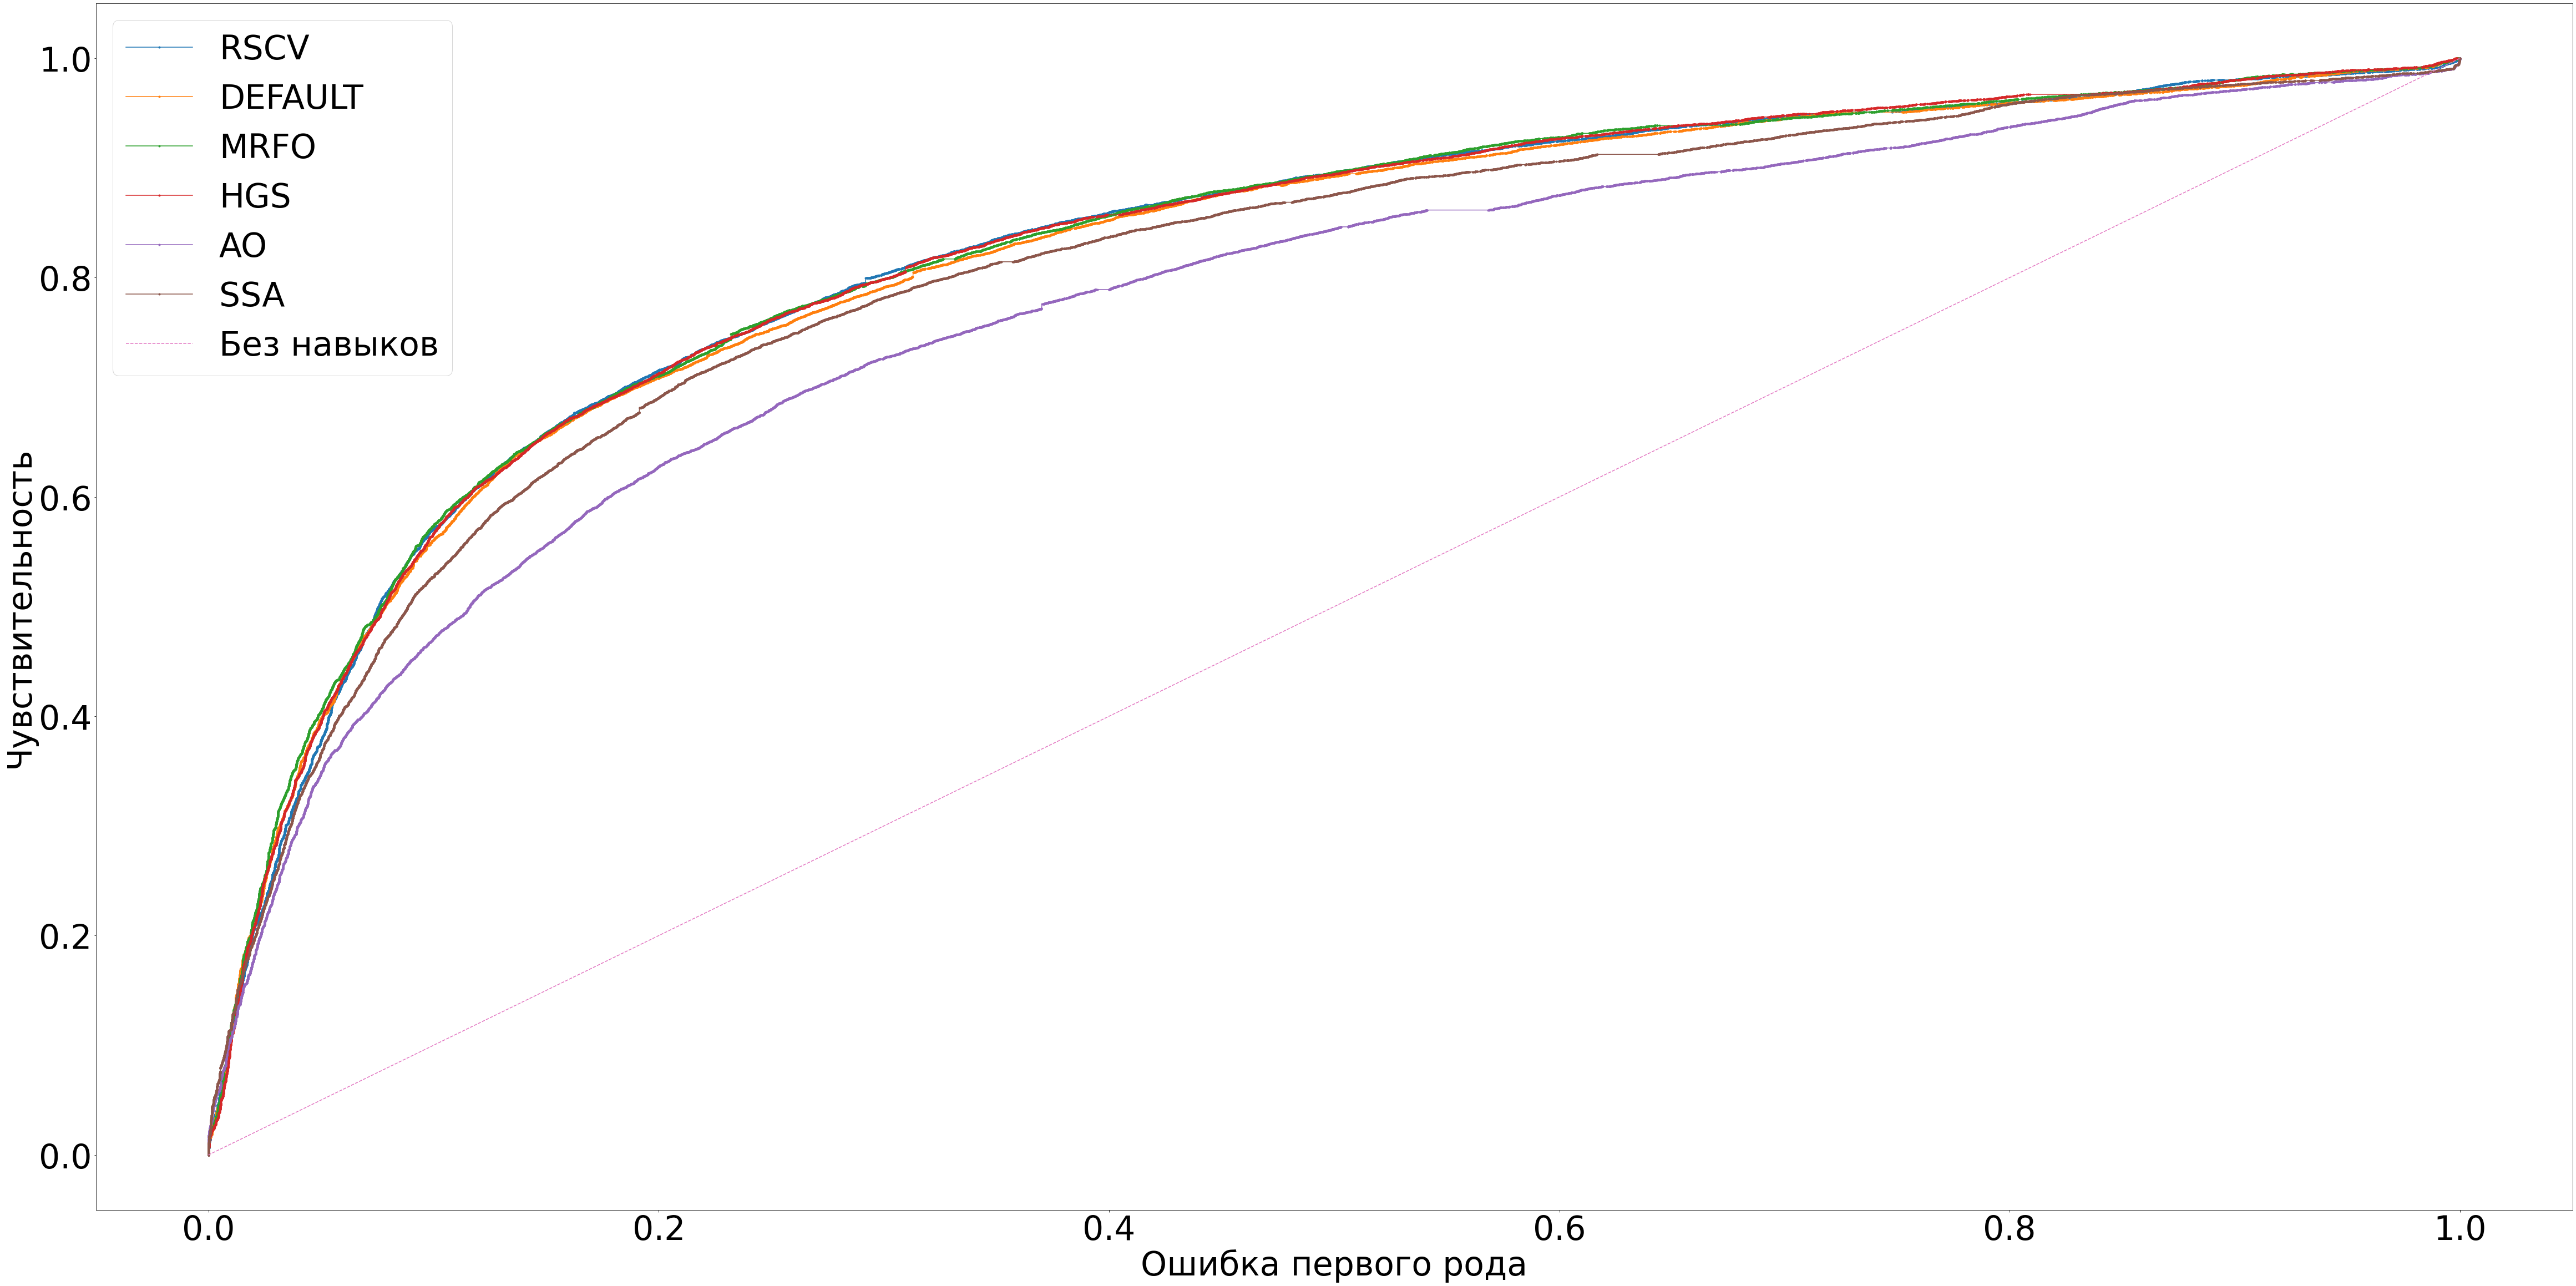

In [202]:
test(LS_best, "LS", "EN")

Validate models trained with LS on SA
RSCV
Balanced accuracy 0.86176: 
Accuracy 0.86176: 
Confusion matrix
 [[5871 1078]
 [ 198 2083]]
ROC: 0.87903

DEFAULT
Balanced accuracy 0.81127: 
Accuracy 0.81127: 
Confusion matrix
 [[5366 1583]
 [ 159 2122]]
ROC: 0.85125

MRFO
Balanced accuracy 0.82091: 
Accuracy 0.82091: 
Confusion matrix
 [[5453 1496]
 [ 157 2124]]
ROC: 0.85794

HGS
Balanced accuracy 0.80325: 
Accuracy 0.80325: 
Confusion matrix
 [[5279 1670]
 [ 146 2135]]
ROC: 0.84784

AO
Balanced accuracy 0.68646: 
Accuracy 0.68646: 
Confusion matrix
 [[4219 2730]
 [ 164 2117]]
ROC: 0.76762

SSA
Balanced accuracy 0.85590: 
Accuracy 0.85590: 
Confusion matrix
 [[5886 1063]
 [ 267 2014]]
ROC: 0.86499



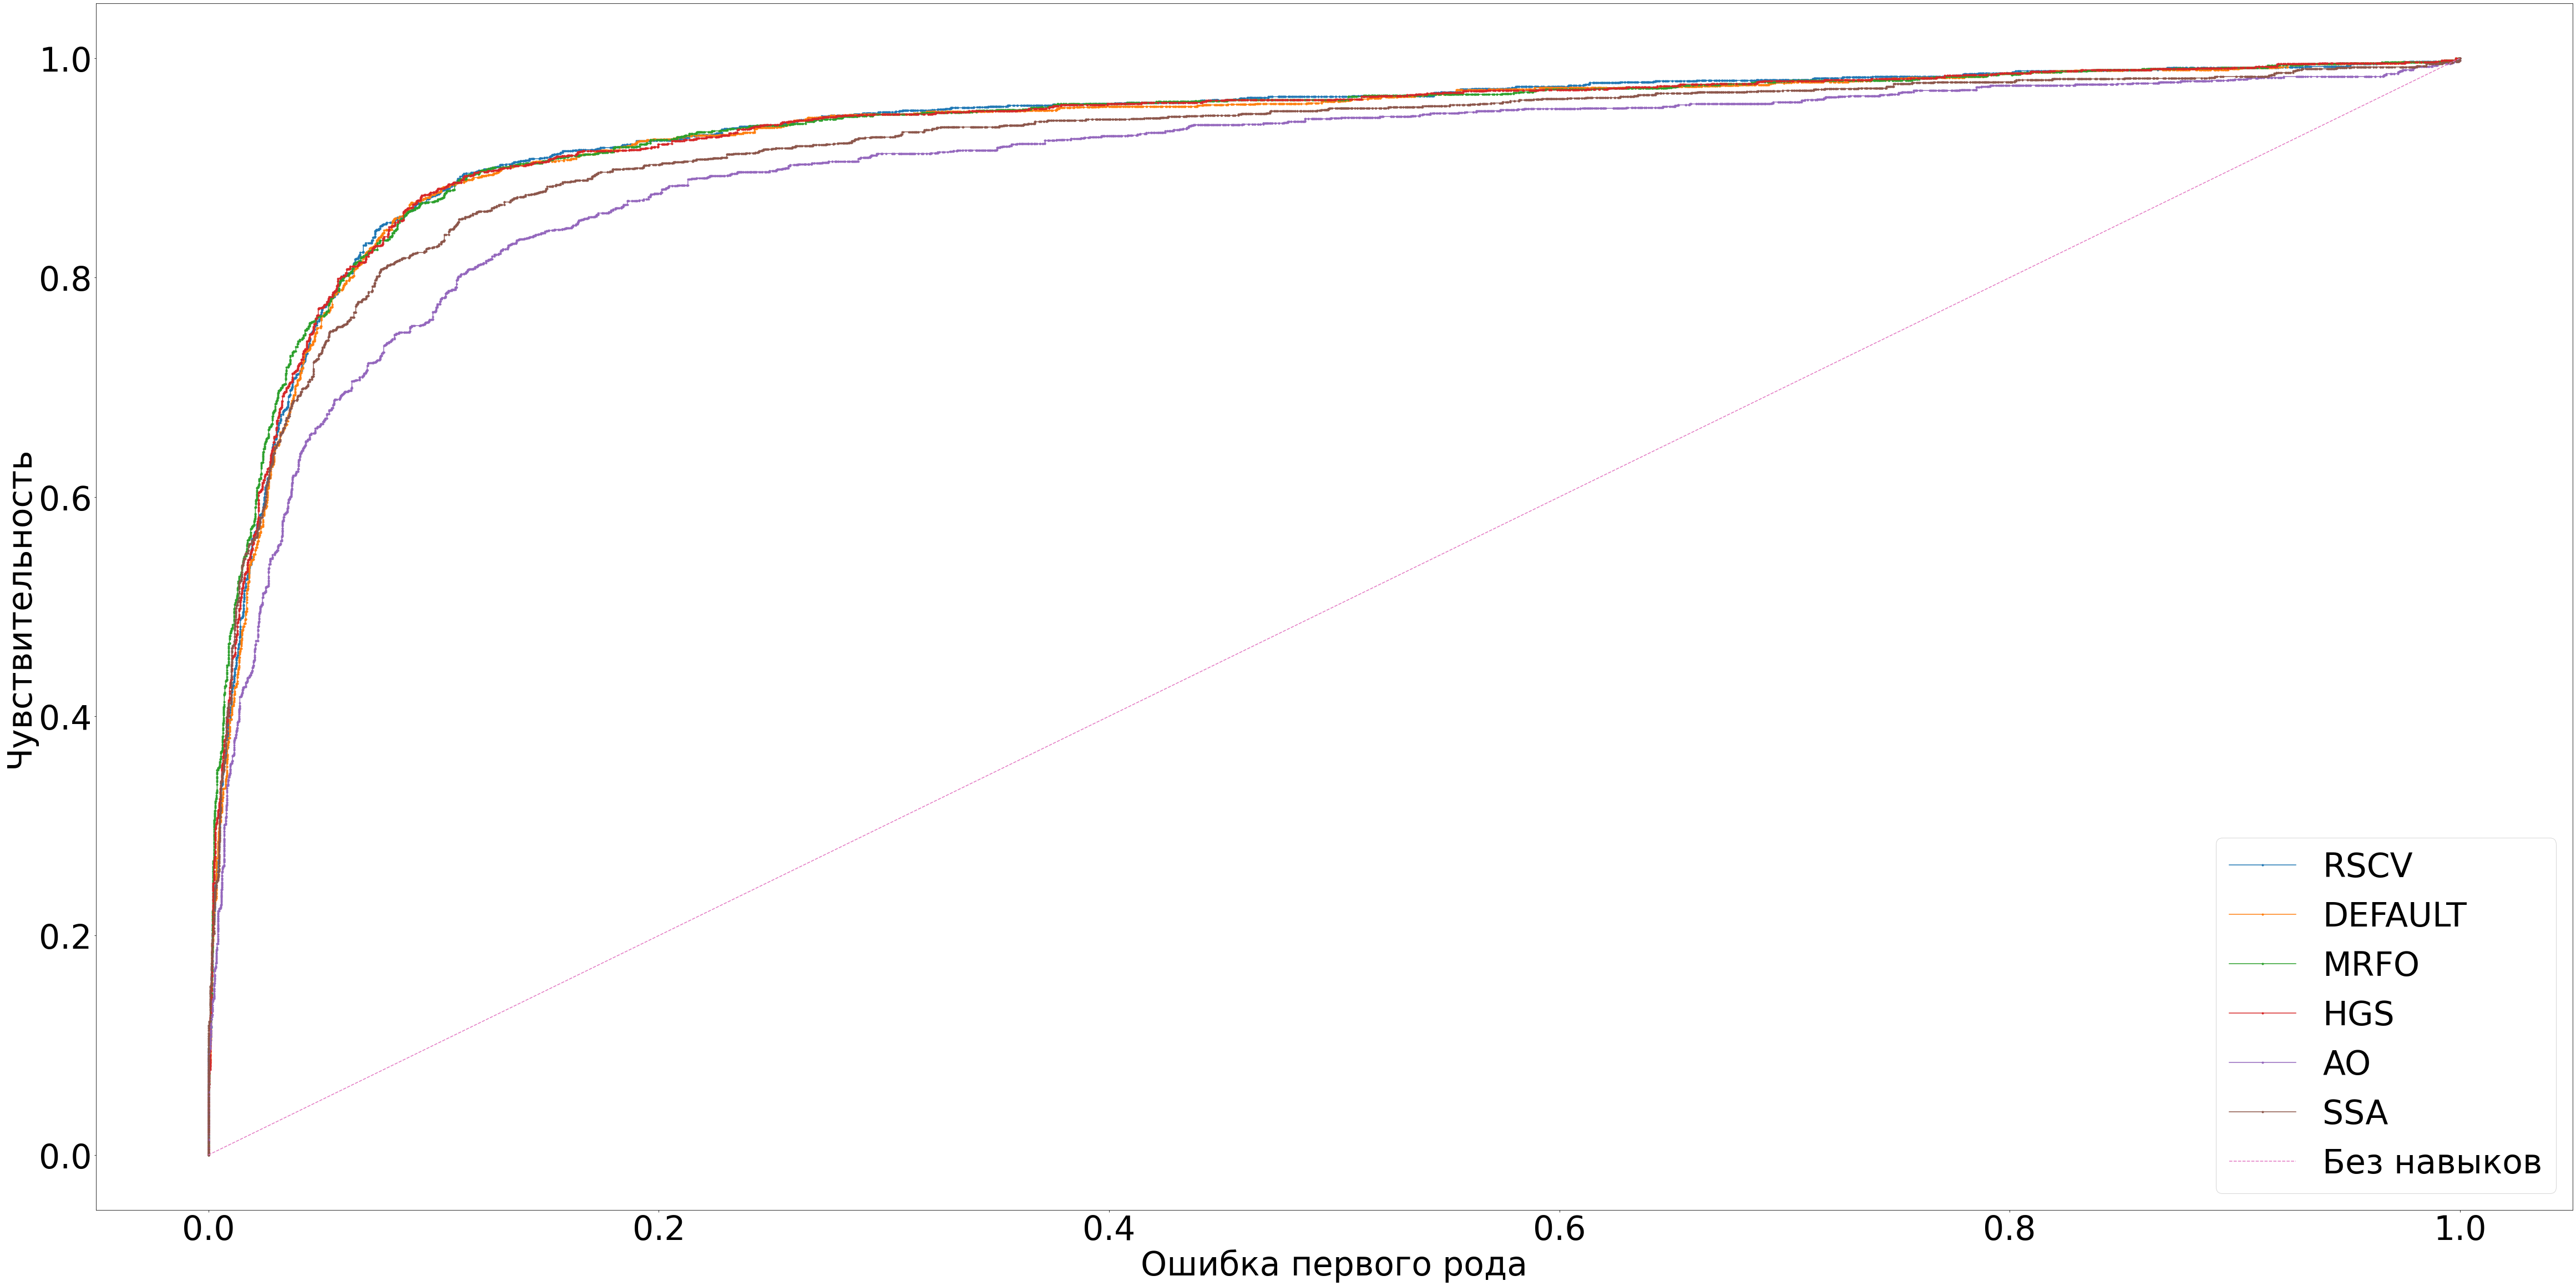

In [203]:
test(LS_best, "LS", "SA")

In [196]:
print('LS RSCV', best_LS_RSCV)
print('LS MRFO', best_LS_MRFO)
print('LS HGS', best_LS_HGS)
print('LS SSA', best_LS_SSA)
print('LS AO', best_LS_AO)

LS RSCV [0.001, 1, 1]
LS MRFO [0.00013249544077759538, 284.58130618450326, 524.4478472331448]
LS HGS [0.00012818058474586846, 19.308901992337557, 62.5810619981058]
LS SSA [0.011138001216805287, 88.62471475551334, 184.26943590551227]
LS AO [0.14025123923227975, 60.099170750506154, 36.54164527588874]
